In [1]:
import ee
import geemap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import os

# Create directory for images
os.makedirs('project_images', exist_ok=True)

In [2]:
# Initialize Earth Engine
ee.Authenticate()
ee.Initialize(project="earthengine-first-project")
print("✅ Earth Engine initialized successfully")

✅ Earth Engine initialized successfully


## Data Loading and Study Area Setup

In [3]:
# Load training data from CSV
def load_training_points(csv_file_path):
    """
    Load CSV point data and convert to Earth Engine FeatureCollection
    """
    df = pd.read_csv(csv_file_path)
    
    # Validate required columns
    required_columns = ['latitude', 'longitude', 'class']
    if not all(col in df.columns for col in required_columns):
        raise ValueError(f"CSV must contain columns: {required_columns}")
    
    print(f"📊 Loaded {len(df)} training points")
    print(f"Class distribution:\n{df['class'].value_counts()}")
    
    # Convert to Earth Engine FeatureCollection
    features = []
    for _, row in df.iterrows():
        point = ee.Geometry.Point([row['longitude'], row['latitude']])
        feature = ee.Feature(point, {'class': row['class']})
        features.append(feature)
    
    return ee.FeatureCollection(features)

# Load training data and study area
training_points = load_training_points('./ROI/training_data.csv')
bbz = geemap.shp_to_ee("./ROI/banke_one_bz.shp")

print("✅ Data loading completed")

📊 Loaded 2106 training points
Class distribution:
class
0    1381
1     725
Name: count, dtype: int64
✅ Data loading completed


C:\Users\jkwrs\miniconda3\envs\gee_env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Creating a 256th field, but some DBF readers might only support 255 fields
  ogr_write(
C:\Users\jkwrs\miniconda3\envs\gee_env\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Value 179226577.384 of field Shape_Area of feature 0 not successfully written. Possibly due to too larger number with respect to field width
  ogr_write(


## Satellite Imagery Processing

In [4]:
# Cloud masking function
def mask_s2_clouds(image):
    """Masks clouds in Sentinel-2 imagery using QA band"""
    qa = image.select('QA60')
    cloud_bit_mask = 1 << 10
    cirrus_bit_mask = 1 << 11
    mask = (
        qa.bitwiseAnd(cloud_bit_mask)
        .eq(0)
        .And(qa.bitwiseAnd(cirrus_bit_mask).eq(0))
    )
    return image.updateMask(mask).divide(10000)

# Get Sentinel-2 imagery
dataset = (
    ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')
    .filterBounds(bbz)
    .filterDate('2023-01-01', '2023-12-31')  # Using 2023 for actual data
    .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 10))
    .map(mask_s2_clouds)
    .median()
    .clip(bbz)
)

print("✅ Satellite imagery processed")

✅ Satellite imagery processed


## Feature Engineering

In [5]:
def calculate_vegetation_indices(image):
    """Calculate vegetation indices for enhanced feature set"""
    # NDVI - Vegetation health
    ndvi = image.normalizedDifference(['B8', 'B4']).rename('NDVI')
    
    # NDWI - Water content  
    ndwi = image.normalizedDifference(['B3', 'B8']).rename('NDWI')
    
    # EVI - Enhanced vegetation index
    evi = image.expression(
        '2.5 * (NIR - RED) / (NIR + 6 * RED - 7.5 * BLUE + 1)',
        {
            'NIR': image.select('B8'),
            'RED': image.select('B4'),
            'BLUE': image.select('B2')
        }
    ).rename('EVI')
    
    # NDBI - Built-up areas
    ndbi = image.normalizedDifference(['B11', 'B8']).rename('NDBI')
    
    image_with_indices = image.addBands([ndvi, ndwi, evi, ndbi])
    print("✅ Vegetation indices calculated")
    return image_with_indices

# Calculate indices
image_with_indices = calculate_vegetation_indices(dataset)

✅ Vegetation indices calculated


## Training Data Preparation

In [6]:
def extract_training_data(image, training_points, scale=10):
    """Extract spectral values at training point locations"""
    optical_bands = ['B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B8', 'B8A', 'B11', 'B12']
    vegetation_indices = ['NDVI', 'NDWI', 'EVI', 'NDBI']
    
    available_bands = image.bandNames().getInfo()
    feature_bands = [band for band in optical_bands + vegetation_indices if band in available_bands]
    
    print(f"🔧 Using {len(feature_bands)} features for classification")
    
    # Sample image at training points
    training_samples = image.select(feature_bands).sampleRegions(
        collection=training_points,
        properties=['class'],
        scale=scale,
        tileScale=8,
        geometries=False
    )
    
    training_data = geemap.ee_to_df(training_samples)
    training_data = training_data.dropna()
    
    print(f"✅ Extracted {len(training_data)} training samples")
    return training_data, feature_bands

# Extract training features
training_data, feature_bands = extract_training_data(image_with_indices, training_points)

🔧 Using 14 features for classification
✅ Extracted 2084 training samples


## Machine Learning Model

📚 Training samples: 1458, Testing samples: 626

🤖 MODEL PERFORMANCE (WITH REGULARIZATION)
🎯 Test Accuracy: 93.77%
📊 Training Accuracy: 96.57%
⚠️  Overfitting Gap: 2.80%
✅ Overfitting: ACCEPTABLE
📈 Cross-validation Accuracy: 95.06% (+/- 5.05%)

📋 Detailed Metrics:
              precision    recall  f1-score   support

           0       0.96      0.94      0.95       415
           1       0.89      0.93      0.91       211

    accuracy                           0.94       626
   macro avg       0.93      0.94      0.93       626
weighted avg       0.94      0.94      0.94       626



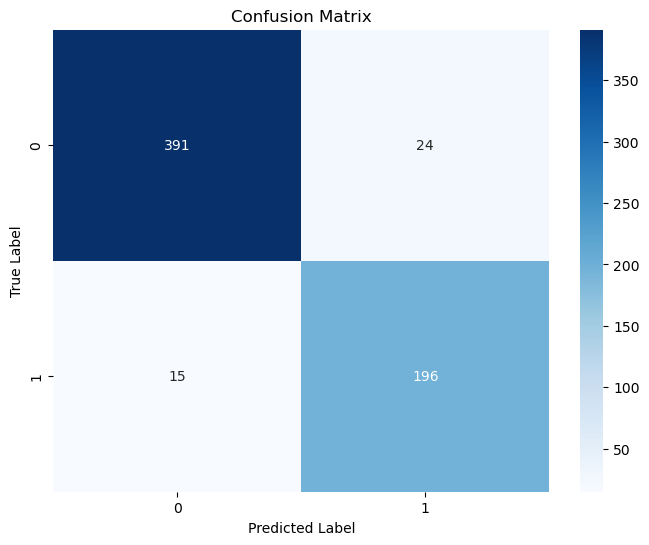

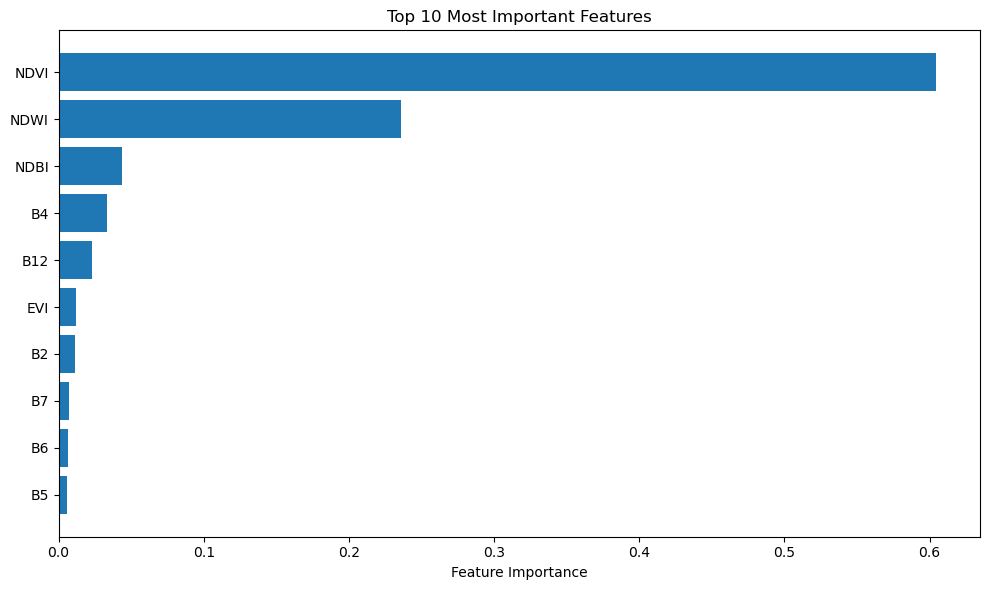


🔝 Top 5 Features:
   feature  importance
10    NDVI    0.604516
11    NDWI    0.236100
13    NDBI    0.043974
2       B4    0.033163
9      B12    0.022827


In [7]:
def train_random_forest(training_data, feature_bands, test_size=0.3):
    """Train and evaluate Random Forest classifier with regularization to prevent overfitting"""
    X = training_data[feature_bands]
    y = training_data['class']
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42, stratify=y
    )
    
    print(f"📚 Training samples: {len(X_train)}, Testing samples: {len(X_test)}")
    
    # Train model with regularization parameters to reduce overfitting
    rf_classifier = RandomForestClassifier(
        n_estimators=150,           # More trees can help generalization
        max_depth=12,               # Limit tree depth
        min_samples_split=15,       # Require more samples to split
        min_samples_leaf=8,         # Require more samples per leaf
        max_features=0.7,           # Use subset of features for each tree
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    
    rf_classifier.fit(X_train, y_train)
    
    # Evaluate model
    y_pred = rf_classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    train_accuracy = rf_classifier.score(X_train, y_train)
    
    # Calculate overfitting gap
    overfitting_gap = train_accuracy - accuracy
    
    print("\n" + "="*50)
    print("🤖 MODEL PERFORMANCE (WITH REGULARIZATION)")
    print("="*50)
    print(f"🎯 Test Accuracy: {accuracy:.2%}")
    print(f"📊 Training Accuracy: {train_accuracy:.2%}")
    print(f"⚠️  Overfitting Gap: {overfitting_gap:.2%}")
    
    if overfitting_gap < 0.05:
        print("✅ Overfitting: ACCEPTABLE")
    elif overfitting_gap < 0.1:
        print("⚠️  Overfitting: MODERATE")
    else:
        print("❌ Overfitting: HIGH")
    
    # Cross-validation for better performance estimate
    from sklearn.model_selection import cross_val_score
    cv_scores = cross_val_score(rf_classifier, X, y, cv=5)
    print(f"📈 Cross-validation Accuracy: {cv_scores.mean():.2%} (+/- {cv_scores.std() * 2:.2%})")
    
    # Detailed classification report
    print("\n📋 Detailed Metrics:")
    print(classification_report(y_test, y_pred))
    
    # Confusion Matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig('project_images/confusion_matrix.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    # Feature Importance
    feature_importance = pd.DataFrame({
        'feature': feature_bands,
        'importance': rf_classifier.feature_importances_
    }).sort_values('importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    top_features = feature_importance.head(10)
    plt.barh(top_features['feature'], top_features['importance'])
    plt.xlabel('Feature Importance')
    plt.title('Top 10 Most Important Features')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.savefig('project_images/feature_importance.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\n🔝 Top 5 Features:")
    print(feature_importance.head())
    
    return rf_classifier, X_test, y_test, y_pred, cv_scores

# Train the model with regularization
rf_classifier, X_test, y_test, y_pred, cv_scores = train_random_forest(training_data, feature_bands)

## Spatial Classification

In [8]:
def classify_study_area(image, training_points, feature_bands):
    """Classify entire study area using Earth Engine"""
    training_samples = image.select(feature_bands).sampleRegions(
        collection=training_points,
        properties=['class'],
        scale=10
    )
    
    ee_classifier = ee.Classifier.smileRandomForest(100).train(
        features=training_samples,
        classProperty='class',
        inputProperties=feature_bands
    )
    
    classified_image = image.select(feature_bands).classify(ee_classifier)
    print("✅ Study area classification completed")
    return classified_image

# Classify the entire area
classified_image = classify_study_area(image_with_indices, training_points, feature_bands)

✅ Study area classification completed


## Results Visualization and Export

In [9]:
def create_project_visualizations(classified_image, study_area, training_points, original_image):
    """Create and export visualizations for project"""
    
    # 1. Study Area Map
    print("🗺️ Creating study area map...")
    study_map = geemap.Map()
    study_map.addLayer(original_image, {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 0.3}, 'Satellite Image')
    study_map.addLayer(study_area, {'color': 'red'}, 'Study Area')
    study_map.centerObject(study_area, 9)
    study_map.save('project_images/study_area.png')
    
    # 2. Classification Results Map
    print("🎨 Creating classification map...")
    class_map = geemap.Map()
    classification_vis = {'min': 0, 'max': 1, 'palette': ['red', 'green']}
    class_map.addLayer(classified_image, classification_vis, 'Forest Classification')
    class_map.addLayer(study_area, {'color': 'blue'}, 'Study Area')
    class_map.add_legend(legend_dict={'Forest': 'green', 'Non-Forest': 'red'})
    class_map.centerObject(study_area, 9)
    class_map.save('project_images/classification_map.png')
    
    # 3. Training Data Map
    print("📍 Creating training data map...")
    training_map = geemap.Map()
    forest_points = training_points.filter(ee.Filter.eq('class', 1))
    non_forest_points = training_points.filter(ee.Filter.eq('class', 0))
    
    training_map.addLayer(forest_points.style(color='green', pointSize=4), {}, 'Forest Samples')
    training_map.addLayer(non_forest_points.style(color='red', pointSize=4), {}, 'Non-Forest Samples')
    training_map.addLayer(study_area, {'color': 'blue'}, 'Study Area')
    training_map.centerObject(study_area, 9)
    training_map.save('project_images/training_data.png')
    
    print("✅ All project images exported to 'project_images/' folder")
    
    return study_map, class_map, training_map

# Generate portfolio images
study_map, class_map, training_map = create_project_visualizations(
    classified_image, bbz, training_points, dataset
)

🗺️ Creating study area map...
🎨 Creating classification map...
📍 Creating training data map...
✅ All project images exported to 'project_images/' folder


## Area Statistics and Final Results


📐 AREA STATISTICS
🌳 Non-Forest: 48.5 km² (24.6%)
🌳 Forest: 148.5 km² (75.4%)
📏 Total Study Area: 197.0 km²


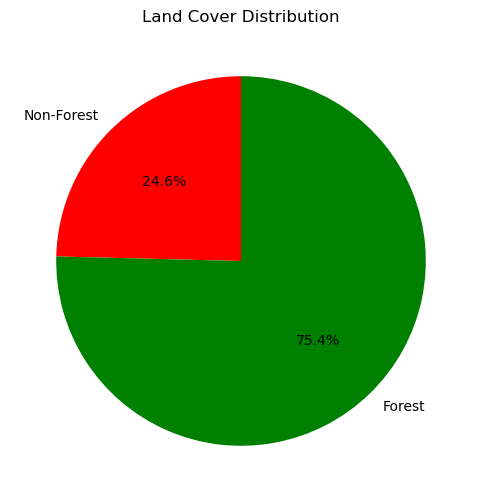

In [13]:
def calculate_area_statistics(classified_image, study_area):
    """Calculate and display area statistics with correct percentage calculation"""
    area_image = ee.Image.pixelArea().addBands(classified_image)
    
    area_stats = area_image.reduceRegion(
        reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
        geometry=study_area,
        scale=10,
        maxPixels=1e9
    )
    
    stats = area_stats.getInfo()
    
    print("\n" + "="*50)
    print("📐 AREA STATISTICS")
    print("="*50)
    
    # First calculate total area and collect class areas
    class_areas = {}
    total_area = 0
    
    for group in stats['groups']:
        class_val = group['class']
        area_km2 = group['sum'] / 1e6
        class_areas[class_val] = area_km2
        total_area += area_km2
    
    # Now calculate percentages and display
    for class_val, area_km2 in class_areas.items():
        percentage = (area_km2 / total_area) * 100
        
        class_name = 'Forest' if class_val == 1 else 'Non-Forest'
        print(f"🌳 {class_name}: {area_km2:.1f} km² ({percentage:.1f}%)")
    
    print(f"📏 Total Study Area: {total_area:.1f} km²")
    
    # Create area distribution pie chart
    plt.figure(figsize=(8, 6))
    areas = [class_areas.get(0, 0), class_areas.get(1, 0)]  # Non-forest, Forest
    labels = ['Non-Forest', 'Forest']
    colors = ['red', 'green']
    
    plt.pie(areas, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
    plt.title('Land Cover Distribution')
    plt.savefig('project_images/area_distribution.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    return stats

# Calculate final statistics with corrected percentage calculation
area_stats = calculate_area_statistics(classified_image, bbz)